In [27]:
import os
from lca_algebraic import initProject
import pandas as pd
import numpy as np
import lca_algebraic as agb
from lca_algebraic import *
from lca_algebraic.stats import * 
import bw2data, bw2io
import bw2calc
from premise import *
import premise as prm
from premise.geomap import Geomap
import pickle
from itertools import product 
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colormaps
matplotlib.style.use('seaborn-v0_8-whitegrid') #seaborn-v0_8-whitegrid  tableau-colorblind10

In [2]:
import sys 
sys.path.append('/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/') 
from utils import *
from utils.setup import *
from utils.setup import chosen_methods
from utils.getAct import *
from utils.utils import *
from utils.switchElec import *

modify the setup.py file for reading Parameter excel sheet. here we use 'data/p_file/p_tech_perSSP_Y.xlsx' as the technology parameter file.  
Define your chosen methods in the setup.py file. Current methods are:  [('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'), ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')]
Mapping premise_remind_DB to SSPx:  {'SSP1-PkBudg500': 'ssp119', 'SSP1-PkBudg1150': 'ssp126', 'SSP2-Base': 'ssp245', 'SSP5-Base': 'ssp585'}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
utils.switchElec is to update an UPRs with the switch elec parameter, allow users to switch manuf. electricity grid per their defined locations - market group or grid-specific


In [3]:
bw2data.projects.set_current('iveo_v1')
mybio = bw2data.Database("biosphere3")
initProject("iveo_v1")

Biosphere database already present!!! No setup is needed


### init

In [4]:
pdb = bw.Database("iveo_Parameterized_v1")
print(len(pdb), PDB_NAME)

384 iveo_Parameterized_v1


In [5]:
# use .loadParams if happy with P already defined
#resetParams()
agb.loadParams()
#agb.list_parameters()

[ParamRegistry] Param NMC622_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param NCA_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LFP_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LTO_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_battery_cell_density was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_NG_MJperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param LSB_cell_assmb_elec_kWhperkg was already defined in '<project>' : overriding.
[ParamRegistry] Param g_truck_vehicle_prod_lightweighting was already defined in '<project>' : overriding.
[ParamRegistry] Param battery_total_capacity_for_gtruck was already defined in '<project>' : overriding.
[ParamRegistry] Param biodiesel_UCO_perc was already defined in '<project>' : overriding.
[ParamRegistry] Pa

### A.1 agb, prepare tech (diesel) UPR
#### parameters for kg diesel, sheet"F2_fuel_d_whbio", P group "diesel"

In [6]:
biodiesel_UCO_perc = newFloatParam(
        name="biodiesel_UCO_perc",
        default= 0.011 ,
        distrib=stats.DistributionType.LINEAR,
        min= 0.00925,	  
        max= 0.01225,
        group="diesel",
        description="SSP245 BAU 2030 perct",
        unit="fraction",
    )

biodiesel_rapeseedoil_perc = newFloatParam(
        name="biodiesel_rapeseedoil_perc",
        default= 0.011 ,
        distrib=stats.DistributionType.LINEAR,
        min= 0.00925,	
        max= 0.01225,
        group="diesel",
        description="SSP245 BAU 2030 perct",
        unit="fraction",
    )

biodiesel_soybeanoil_perc = newFloatParam(
        name="biodiesel_soybeanoil_perc",
        default= 0.011 ,
        distrib=stats.DistributionType.LINEAR,
        min= 0.00925,	
        max= 0.01225,
        group="diesel",
        description="SSP245 BAU 2030 perct",
        unit="fraction",
    )


biodiesel_algea_perc = newFloatParam(
        name="biodiesel_algea_perc",
        default= 0.011 ,
        distrib=stats.DistributionType.LINEAR,
        min= 0.00925,	
        max= 0.01225,
        group="diesel",
        description="SSP245 BAU 2030 perct",
        unit="fraction",
    )


conv_diesel_perc = newFloatParam(
        name="conv_diesel_perc",
        default= 0.956,
        distrib=stats.DistributionType.LINEAR,
        min= 0.951,	
        max= 0.963,
        group="diesel",
        description="SSP245 BAU 2030 perct",
        unit="fraction",
    )

### A.2 create a new UPR for soybean oil (lacking in prm), which is big source of biodiesel feedstock other than rapeseed oil

In [8]:
#empty list to store new UPR soybean oil under SSPx,Yt
soyoil_allsspyear = [] 

for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        bg_db_ssp_yr = bg_ei_ + prm_name + "_" + str(year_t)            # backgroun database (BD) to use for SSP[x], Year[t]
        copied_prm_UPR_suffix = "_from_" + prm_name + "_" + str(year_t) # copy UPR from BD to PDB for further use/modification if needed
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t)          # naming on any new UPRs created in PDB
    
    
        # use getAct.findActwhRPSSP function as this UPR has multiple ref product
        bd_soy_tocopy = getAct.findActwhRPSSP('esterification of soybean oil', rp="fatty acid methyl ester", multiplerp = True, 
                                              loc = "US", db_name = bg_db_ssp_yr)
        bd_soy_copy_toPDB = agb.copyActivity(PDB_NAME, bd_soy_tocopy, bd_soy_tocopy.as_dict()["name"] + copied_prm_UPR_suffix )
        
        soyoil_final = agb.newActivity(
                db_name = PDB_NAME,
                name="biodiesel, from soybean oil, created for IVEO_" +  newUPR_suffix, loc = 'CA-QC',
                code = "biodiesel, from soybean oil, created for IVEO_" + newUPR_suffix  ,
                unit="kilogram",
                exchanges={
                    agb.findActivity(bd_soy_copy_toPDB.as_dict()["name"], db_name = PDB_NAME) : 1.0006,  
                    #following exchange using same UPR and amount from "biodiesel, from rapeseed oil, at fuelling station | CAZ"
                    agb.findActivity('infrastructure construction, for regional distribution of oil product', loc = 'RoW', 
                                     db_name = bg_db_ssp_yr): 2.6e-10, 
                    agb.findActivity('market for fly ash and scrubber sludge', loc = 'RoW', 
                                     db_name = bg_db_ssp_yr): -0.000168, 
                    agb.findActivity('market for heat, central or small-scale, other than natural gas', loc = 'RoW', 
                                     db_name = bg_db_ssp_yr): 0.000584, 
                    agb.findActivity('market for transport, freight train', loc = 'RoW', 
                                     db_name = bg_db_ssp_yr): 0.0336, 
                    agb.findActivity('market for municipal solid waste', loc = 'CA-QC', 
                                     db_name = bg_db_ssp_yr): -6.27e-6, 
                    agb.findActivity('treatment of wastewater, average, wastewater treatment', loc = 'CA-QC', 
                                     db_name = bg_db_ssp_yr): -6.89e-7,
                    agb.findActivity('market for electricity, low voltage', loc = 'CA-QC', 
                                     db_name = bg_db_ssp_yr): 0.0067,
                    agb.findActivity('market for tap water', loc = 'CA-QC', 
                                     db_name = bg_db_ssp_yr): 0.000689,
                },
            )
        
        for exc in soyoil_final.getExchange(name = "*", single=False): 
            exc['type']='technosphere'
            exc.save()
        soyoil_final.setOutputAmount(1)
        
        #agb.printAct(soyoil_final)
        print(f"end of creating a new UPR in {PDB_NAME} for biodiesel soybean oil for SSP {prm_name} and year {year_t}, relying on BD {bg_db_ssp_yr}")
        
        #adding to list: 
        soyoil_allsspyear.append(soyoil_final)
        

'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP1-PkBudg500_2030' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg500_2030' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP1-PkBudg500 and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg500_2030
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP1-PkBudg500_2040' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg500_2040' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP1-PkBudg500 and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg500_2040
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP1-PkBudg500_2050' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg500_2050' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP1-PkBudg500 and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg500_2050
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP1-PkBudg1150_2030' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg1150_2030' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP1-PkBudg1150 and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg1150_2030
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP1-PkBudg1150_2040' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg1150_2040' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP1-PkBudg1150 and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg1150_2040
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP1-PkBudg1150_2050' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg1150_2050' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP1-PkBudg1150 and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg1150_2050
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP2-Base_2030' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP2-Base_2030' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP2-Base and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP2-Base_2030
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP2-Base_2040' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP2-Base_2040' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP2-Base and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP2-Base_2040
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP2-Base_2050' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP2-Base_2050' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP2-Base and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP2-Base_2050
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP5-Base_2030' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2030' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP5-Base and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP5-Base_2030
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP5-Base_2040' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2040' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP5-Base and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP5-Base_2040
'esterification of soybean oil' (kilogram, RoW, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, US, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of soybean oil' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>
'esterification of vegetable oils and animal fats, average mix' (kilogram, BR, None) <class 'bw2data.backends.peewee.proxies.Activity'>


Activity 'esterification of soybean oil_from__remind_SSP5-Base_2050' was already in 'iveo_Parameterized_v1'. Overwriting it
Activity 'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2050' was already in 'iveo_Parameterized_v1'. Overwriting it


end of creating a new UPR in iveo_Parameterized_v1 for biodiesel soybean oil for SSP _remind_SSP5-Base and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP5-Base_2050


#### make sure all  new soybean UPRs is created and can be searched for adding to final diesel mix

In [9]:
for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t) 
        soyoil_final = agb.findActivity("biodiesel, from soybean oil, created for IVEO_" +  newUPR_suffix, 
                                     db_name = PDB_NAME)
        print(soyoil_final.as_dict()["name"])

biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg500_2030
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg500_2040
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg500_2050
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg1150_2030
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg1150_2040
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP1-PkBudg1150_2050
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP2-Base_2030
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP2-Base_2040
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP2-Base_2050
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2030
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2040
biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2050


### A.3 create final diesel UPR 

In [10]:
diesel_final_allsspyear = []

for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        
        bg_db_ssp_yr = bg_ei_ + prm_name + "_" + str(year_t)            # backgroun database (BD) to use for SSP[x], Year[t]
        copied_prm_UPR_suffix = "_from_" + prm_name + "_" + str(year_t) # copy UPR from BD to PDB for further use/modification if needed
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t)          # naming on any new UPRs created in PDB

        # final diesel with diff% as Parameter: 
        diesel_final = agb.newActivity(
                db_name = PDB_NAME,
                name="Diesel_mix_with_conv_and_biodiesel_perkg_" + newUPR_suffix,
                code = "Diesel_mix_with_conv_and_biodiesel_perkg_" + newUPR_suffix,
                unit="kilogram",
                exchanges={
                    agb.findActivity('biodiesel, from used cooking oil, at fuelling station', loc = 'RER', 
                                     db_name = bg_db_ssp_yr): biodiesel_UCO_perc ,  
                    agb.findActivity('biodiesel, from rapeseed oil, at fuelling station', loc = 'CAZ', 
                                     db_name = bg_db_ssp_yr): biodiesel_rapeseedoil_perc , 
                    agb.findActivity('biodiesel, from algae, at fuelling station', loc = 'RER', 
                                     db_name = bg_db_ssp_yr): biodiesel_algea_perc  , 

                    # get the new UPR created in the PDB for soybean oil, with the same naming rule:
                    agb.findActivity("biodiesel, from soybean oil, created for IVEO_" +  newUPR_suffix, 
                                     db_name = PDB_NAME) : biodiesel_soybeanoil_perc,  
                    # not sure what's the diff between "market for diesel, low-sulfur" vs "... 40/60-year period"
                    agb.findActivity('market for diesel, low-sulfur', loc= "CAZ", 
                                     db_name = bg_db_ssp_yr): conv_diesel_perc , 
                
                },
            )
        
        for exc in diesel_final.getExchange(name = "*", single=False): 
            exc['type']='technosphere'
            exc.save()
        diesel_final.setOutputAmount(1)
        
        agb.printAct(diesel_final)
        print(f"end of creating a new UPR for final diesel for SSP {prm_name} and year {year_t}, relying on BD {bg_db_ssp_yr}")
        
        #adding to list: 
        diesel_final_allsspyear.append(diesel_final)
        


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2030 (1.000000 kilogram)  \
                                                                                                                                          input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                             
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                             
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                             
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                             
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                             

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP1-PkBudg500 and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg500_2030


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2040 (1.000000 kilogram)  \
                                                                                                                                          input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                             
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                             
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                             
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                             
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                             

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP1-PkBudg500 and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg500_2040


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2050 (1.000000 kilogram)  \
                                                                                                                                          input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                             
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                             
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                             
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                             
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                             

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP1-PkBudg500 and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg500_2050


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2030 (1.000000 kilogram)  \
                                                                                                                                           input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                              
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                              
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                              
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                              
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                              

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP1-PkBudg1150 and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg1150_2030


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2040 (1.000000 kilogram)  \
                                                                                                                                           input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                              
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                              
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                              
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                              
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                              

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP1-PkBudg1150 and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg1150_2040


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2050 (1.000000 kilogram)  \
                                                                                                                                           input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                              
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                              
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                              
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                              
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                              

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP1-PkBudg1150 and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP1-PkBudg1150_2050


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2030 (1.000000 kilogram)  \
                                                                                                                                     input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                        
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                        
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                        
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                        
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                        

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP2-Base and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP2-Base_2030


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2040 (1.000000 kilogram)  \
                                                                                                                                     input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                        
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                        
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                        
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                        
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                        

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP2-Base and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP2-Base_2040


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2050 (1.000000 kilogram)  \
                                                                                                                                     input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                        
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                        
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                        
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                        
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                        

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP2-Base and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP2-Base_2050


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2030 (1.000000 kilogram)  \
                                                                                                                                     input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                        
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                        
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                        
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                        
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                        

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP5-Base and year 2030, relying on BD ecoinvent_cutoff_3.9_remind_SSP5-Base_2030


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2040 (1.000000 kilogram)  \
                                                                                                                                     input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                        
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                        
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                        
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                        
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                        

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP5-Base and year 2040, relying on BD ecoinvent_cutoff_3.9_remind_SSP5-Base_2040


Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050 (1.000000 kilogram)  \
                                                                                                                                     input   
biodiesel, from algae, at fuelling station            biodiesel, from algae, at fuelling station[RER]                                        
biodiesel, from rapeseed oil, at fuelling station   biodiesel, from rapeseed oil, at fuelling stat...                                        
biodiesel, from soybean oil, created for IVEO__...  biodiesel, from soybean oil, created for IVEO_...                                        
biodiesel, from used cooking oil, at fuelling s...  biodiesel, from used cooking oil, at fuelling ...                                        
market for diesel, low-sulfur                                      market for diesel, low-sulfur[CAZ]                                        

                                                                                \
                                                                        amount   
biodiesel, from algae, at fuelling station                biodiesel_algea_perc   
biodiesel, from rapeseed oil, at fuelling station   biodiesel_rapeseedoil_perc   
biodiesel, from soybean oil, created for IVEO__...   biodiesel_soybeanoil_perc   
biodiesel, from used cooking oil, at fuelling s...          biodiesel_UCO_perc   
market for diesel, low-sulfur                                 conv_diesel_perc   

                                                              
                                                        unit  
biodiesel, from algae, at fuelling station          kilogram  
biodiesel, from rapeseed oil, at fuelling station   kilogram  
biodiesel, from soybean oil, created for IVEO__...  kilogram  
biodiesel, from used cooking oil, at fuelling s...  kilogram  
market for diesel, low-sulfur                       kilogram

end of creating a new UPR for final diesel for SSP _remind_SSP5-Base and year 2050, relying on BD ecoinvent_cutoff_3.9_remind_SSP5-Base_2050


### get already created UPR:

In [6]:
diesel_final_allsspyear = [] 
for prm_name in ssp_scn:
    for year_t in ssp_yr: 
        bg_db_ssp_yr = bg_ei_ + prm_name + "_" + str(year_t)            # backgroun database (BD) to use for SSP[x], Year[t]
        copied_prm_UPR_suffix = "_from_" + prm_name + "_" + str(year_t) # copy UPR from BD to PDB for further use/modification if needed
        newUPR_suffix =  "_wh_" + prm_name + "_" + str(year_t)          # naming on any new UPRs created in PDB
        act = agb.findActivity( db_name = PDB_NAME, name="Diesel_mix_with_conv_and_biodiesel_perkg_" + newUPR_suffix )
        diesel_final_allsspyear.append(act)

len(diesel_final_allsspyear)

12

## B. calculate diesel UPR under different SSP with yearly P

In [7]:
root_path = '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/'
p_file = os.path.abspath(os.path.join(root_path, 'data/P_files/p_tech_perSSP_Y.xlsx'))
yearlyParams = loadYearlyParams(PARAMS_FILE = p_file, s_name = "F2_fuel_d_whbio", years = [2030,2035,2040,2045,2050], SSP = "ssp585") 
#yearlyParams

In [12]:
#utils._plot_params([p for p in params._param_registry().all()], size=360, figsize=(12,8))

#### B0. testing read in P file

In [13]:
for diesel_final in diesel_final_allsspyear:
    # need a matched YearlyParams for each SSPx:
    str1 = diesel_final.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int( str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
    
    yearlyParams = loadYearlyParams(PARAMS_FILE = p_file, s_name = "F2_fuel_d_whbio", years = [year_to_get_inP], SSP = ssp_to_get_inP) 
    print(f"for SSP {ssp_to_get_inP}, year {year_to_get_inP}, P:  {yearlyParams}" )

for SSP ssp119, year 2030, P:  {'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000000000001], 'conv_diesel_perc': [0.956]}
for SSP ssp119, year 2040, P:  {'biodiesel_UCO_perc': [0.015500000000000014], 'biodiesel_rapeseedoil_perc': [0.015500000000000014], 'biodiesel_soybeanoil_perc': [0.015500000000000014], 'biodiesel_algea_perc': [0.015500000000000014], 'conv_diesel_perc': [0.938]}
for SSP ssp119, year 2050, P:  {'biodiesel_UCO_perc': [0.036574999999999996], 'biodiesel_rapeseedoil_perc': [0.036574999999999996], 'biodiesel_soybeanoil_perc': [0.036574999999999996], 'biodiesel_algea_perc': [0.036574999999999996], 'conv_diesel_perc': [0.8537]}
for SSP ssp126, year 2030, P:  {'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000

### B.1  read in diesel% parameter under different SSPx in the calc

- using the UPR names created in PDB, to map with the corresponding SSPx' yearlyP to get
- as the URP names has different naming "_remind_SSP1-PkBudg1150" from the Parameter file, need a mapping dict
- once YearlyP under a SSPx extracted, run the agb.lca() calculation 

In [8]:
#final output to be appended
diesel_lcia_dict = {}
GWP1_list, GWP2_list, SSP_list, Year_list = [],[],[],[]

for diesel_final in diesel_final_allsspyear:
    # need a matched YearlyParams for each SSPx:
    str1 = diesel_final.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int(str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
    
    
    yearlyParams = loadYearlyParams(PARAMS_FILE = p_file, s_name = "F2_fuel_d_whbio", years = [year_to_get_inP], SSP = ssp_to_get_inP) 
    print(yearlyParams)
    
    d_df = agb.multiLCAAlgebric(models=[
                (diesel_final, 1)], 
                methods = [('IPCC 2021 no LT', 'climate change no LT','global warming potential (GWP100) no LT'), 
                         ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')],   
                **yearlyParams
                )
    
    print(f"end of running LCA calc for SSP {ssp_to_get_inP} and year {year_to_get_inP} for {diesel_final} ")
    display(d_df)
    
    # prepare for final DF: 
    GWP1 = d_df.iloc[:,0].values[0]
    GWP2 = d_df.iloc[:,1].values[0]
    GWP1_list.append(GWP1)
    GWP2_list.append(GWP2)
    SSP_list.append(ssp_to_get_inP) 
    Year_list.append(year_to_get_inP)

    
    # assign df as value to each UPR name (used as key)
    diesel_lcia_dict[str1] = d_df

{'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000000000001], 'conv_diesel_perc': [0.956]}
end of running LCA calc for SSP ssp119 and year 2030 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2030' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2030,0.765528,0.219874


{'biodiesel_UCO_perc': [0.015500000000000014], 'biodiesel_rapeseedoil_perc': [0.015500000000000014], 'biodiesel_soybeanoil_perc': [0.015500000000000014], 'biodiesel_algea_perc': [0.015500000000000014], 'conv_diesel_perc': [0.938]}
end of running LCA calc for SSP ssp119 and year 2040 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2040' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2040,0.637501,-1.783641


{'biodiesel_UCO_perc': [0.036574999999999996], 'biodiesel_rapeseedoil_perc': [0.036574999999999996], 'biodiesel_soybeanoil_perc': [0.036574999999999996], 'biodiesel_algea_perc': [0.036574999999999996], 'conv_diesel_perc': [0.8537]}
end of running LCA calc for SSP ssp119 and year 2050 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2050' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2050,0.562098,-3.280184


{'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000000000001], 'conv_diesel_perc': [0.956]}
end of running LCA calc for SSP ssp126 and year 2030 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2030' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2030,0.796633,0.446315


{'biodiesel_UCO_perc': [0.015500000000000014], 'biodiesel_rapeseedoil_perc': [0.015500000000000014], 'biodiesel_soybeanoil_perc': [0.015500000000000014], 'biodiesel_algea_perc': [0.015500000000000014], 'conv_diesel_perc': [0.938]}
end of running LCA calc for SSP ssp126 and year 2040 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2040' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2040,0.755632,-0.002557


{'biodiesel_UCO_perc': [0.03325], 'biodiesel_rapeseedoil_perc': [0.03325], 'biodiesel_soybeanoil_perc': [0.03325], 'biodiesel_algea_perc': [0.03325], 'conv_diesel_perc': [0.867]}
end of running LCA calc for SSP ssp126 and year 2050 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2050' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg1150_2050,0.716055,-0.842087


{'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000000000001], 'conv_diesel_perc': [0.956]}
end of running LCA calc for SSP ssp245 and year 2030 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2030' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2030,0.812105,0.618935


{'biodiesel_UCO_perc': [0.009250000000000008], 'biodiesel_rapeseedoil_perc': [0.009250000000000008], 'biodiesel_soybeanoil_perc': [0.009250000000000008], 'biodiesel_algea_perc': [0.009250000000000008], 'conv_diesel_perc': [0.963]}
end of running LCA calc for SSP ssp245 and year 2040 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2040' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2040,0.748105,0.299477


{'biodiesel_UCO_perc': [0.012250000000000011], 'biodiesel_rapeseedoil_perc': [0.012250000000000011], 'biodiesel_soybeanoil_perc': [0.012250000000000011], 'biodiesel_algea_perc': [0.012250000000000011], 'conv_diesel_perc': [0.951]}
end of running LCA calc for SSP ssp245 and year 2050 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2050' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2050,0.666371,-0.200341


{'biodiesel_UCO_perc': [0.01100000000000001], 'biodiesel_rapeseedoil_perc': [0.01100000000000001], 'biodiesel_soybeanoil_perc': [0.01100000000000001], 'biodiesel_algea_perc': [0.01100000000000001], 'conv_diesel_perc': [0.956]}
end of running LCA calc for SSP ssp585 and year 2030 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2030' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2030,0.830704,0.707562


{'biodiesel_UCO_perc': [0.009250000000000008], 'biodiesel_rapeseedoil_perc': [0.009250000000000008], 'biodiesel_soybeanoil_perc': [0.009250000000000008], 'biodiesel_algea_perc': [0.009250000000000008], 'conv_diesel_perc': [0.963]}
end of running LCA calc for SSP ssp585 and year 2040 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2040' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2040,0.817571,0.682525


{'biodiesel_UCO_perc': [0.009250000000000008], 'biodiesel_rapeseedoil_perc': [0.009250000000000008], 'biodiesel_soybeanoil_perc': [0.009250000000000008], 'biodiesel_algea_perc': [0.009250000000000008], 'conv_diesel_perc': [0.963]}
end of running LCA calc for SSP ssp585 and year 2050 for 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050' (kilogram, GLO, None) 


,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050,0.804194,0.595209


In [9]:
lcia_diesel = pd.DataFrame(zip(SSP_list, Year_list, GWP1_list, GWP2_list), columns = ["SSP","Year","GWP100kgCO2e_perkgdiesel", "prm_GWP100_perkgdiesel"])
lcia_diesel

,SSP,Year,GWP100kgCO2e_perkgdiesel,prm_GWP100_perkgdiesel
0,ssp119,2030,0.765528,0.219874
1,ssp119,2040,0.637501,-1.783641
2,ssp119,2050,0.562098,-3.280184
3,ssp126,2030,0.796633,0.446315
4,ssp126,2040,0.755632,-0.002557
5,ssp126,2050,0.716055,-0.842087
6,ssp245,2030,0.812105,0.618935
7,ssp245,2040,0.748105,0.299477
8,ssp245,2050,0.666371,-0.200341
9,ssp585,2030,0.830704,0.707562


## C. contribution analysis 
- using remind_SSP5-Base_2050 as example

In [19]:
diesel_final

'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050' (kilogram, GLO, None)

In [20]:
activities_to_extract=[] 
newUPR_suffix = '_wh__remind_SSP5-Base_2050'

getlci_name = ["biodiesel, from used cooking oil, at fuelling station", "biodiesel, from rapeseed oil, at fuelling station", 
               "biodiesel, from algae, at fuelling station", str("biodiesel, from soybean oil, created for IVEO_" +  newUPR_suffix), 
              "market for diesel, low-sulfur"]
loc_ = ['RER', 'CAZ', 'RER', None , 'CAZ' ]
db_ = ['ecoinvent_cutoff_3.9_remind_SSP5-Base_2050', 'ecoinvent_cutoff_3.9_remind_SSP5-Base_2050', 
       'ecoinvent_cutoff_3.9_remind_SSP5-Base_2050', PDB_NAME , 'ecoinvent_cutoff_3.9_remind_SSP5-Base_2050' ]


for n, l ,d  in zip(getlci_name , loc_, db_) :
    p = findActivity(name=n,  loc =  l,  db_name= d)
    print(p)
    activities_to_extract.append(p) 


'biodiesel, from used cooking oil, at fuelling station' (kilogram, RER, None)
'biodiesel, from rapeseed oil, at fuelling station' (kilogram, CAZ, None)
'biodiesel, from algae, at fuelling station' (kilogram, RER, None)
'biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2050' (kilogram, GLO, None)
'market for diesel, low-sulfur' (kilogram, CAZ, None)


In [21]:
for diesel_final in diesel_final_allsspyear:
    # need a matched YearlyParams for each SSPx:
    str1 = diesel_final.as_dict()["name"]
    str2 = str1.split("remind_")[1]
    year_to_get_inP = int(str2.split("_")[-1] )
    ssp_remind = str2.split("_")[0] 
    ssp_to_get_inP = ssp_remind_Pname_map.get(ssp_remind)
    
    #print(yearlyParams)
    d_df = agb.multiLCAAlgebric(models=[
                (diesel_final, 1)], 
                methods = chosen_methods,   
                **yearlyParams
                )
    

In [22]:
contrib_an = dict()

P_ssp52050 = loadYearlyParams(PARAMS_FILE = p_file, s_name = "F2_fuel_d_whbio", years = [year_to_get_inP], SSP = ssp_to_get_inP)

for a in activities_to_extract:
    #print(a.as_dict()["name"])
    contrib_an[a.as_dict()["name"]] = multiLCAAlgebric( {diesel_final: 1},  
                     chosen_methods,
                     extract_activities=[a], 
                     **P_ssp52050  )

In [23]:
contr_df = pd.concat(contrib_an)
contr_df

,,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]"
"biodiesel, from used cooking oil, at fuelling station",Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050,0.003838,-0.022546
"biodiesel, from rapeseed oil, at fuelling station",Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050,0.021653,-0.005097
"biodiesel, from algae, at fuelling station",Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050,0.015494,-0.011025
"biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2050",Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050,0.008763,-0.014953
"market for diesel, low-sulfur",Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050,0.754447,0.648829


In [24]:
sum_ = contr_df.iloc[: ,0].sum()   
contr_df['Perc_%'] = (contr_df.iloc[: ,0] / sum_) * 100
contr_df.droplevel(1)

,climate change no LT - global warming potential (GWP100) no LT[kg CO2-Eq],"climate change - GWP 100a, incl. H and bio CO2[kg CO2-Eq]",Perc_%
"biodiesel, from used cooking oil, at fuelling station",0.003838,-0.022546,0.477228
"biodiesel, from rapeseed oil, at fuelling station",0.021653,-0.005097,2.692451
"biodiesel, from algae, at fuelling station",0.015494,-0.011025,1.926638
"biodiesel, from soybean oil, created for IVEO__wh__remind_SSP5-Base_2050",0.008763,-0.014953,1.089612
"market for diesel, low-sulfur",0.754447,0.648829,93.814071


## D. MC and GSA

Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...
Generating samples ...


/Users/susierwu/miniconda3/envs/prm/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10000) is equal to `2^n`.
        
  warnings.warn(msg)


Transforming samples ...


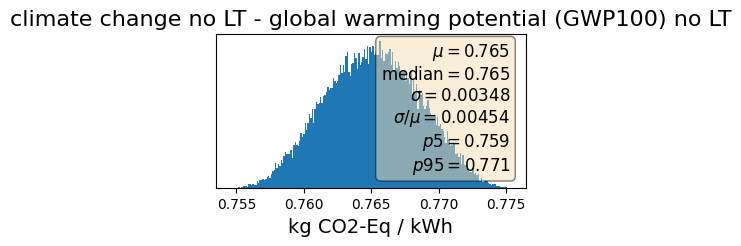

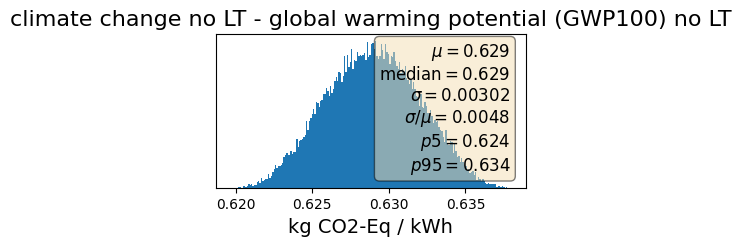

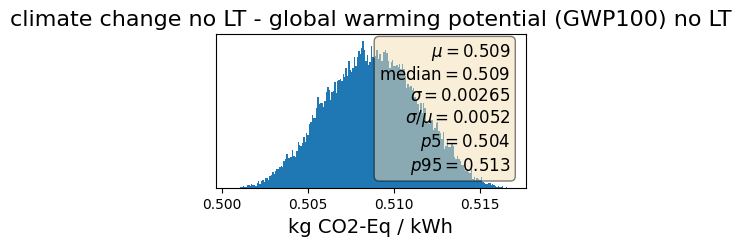

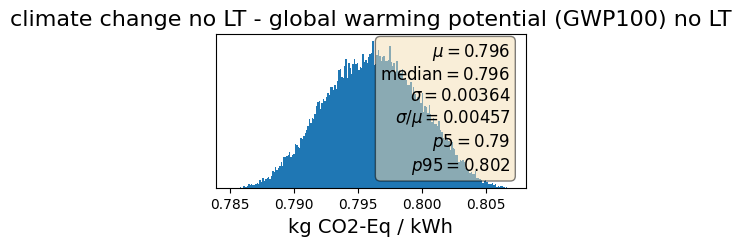

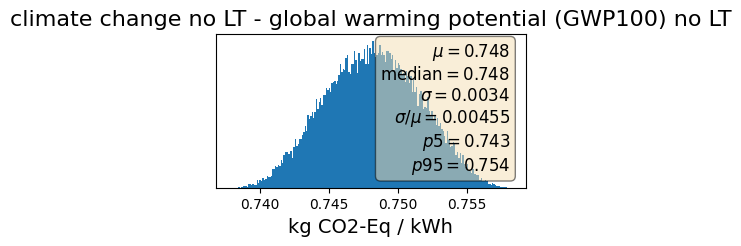

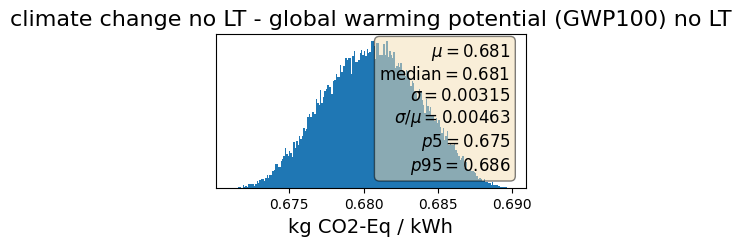

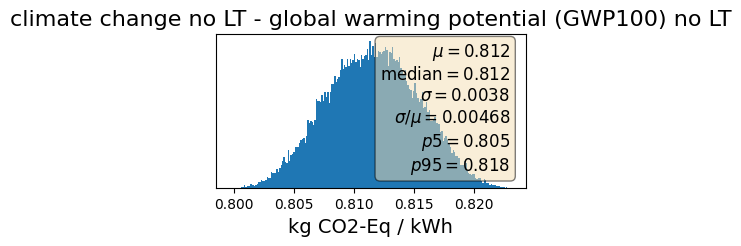

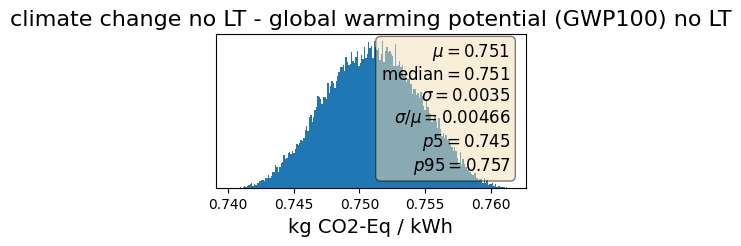

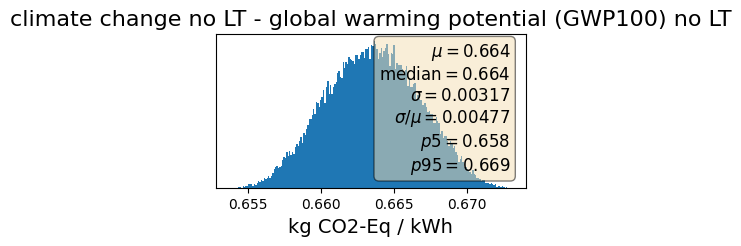

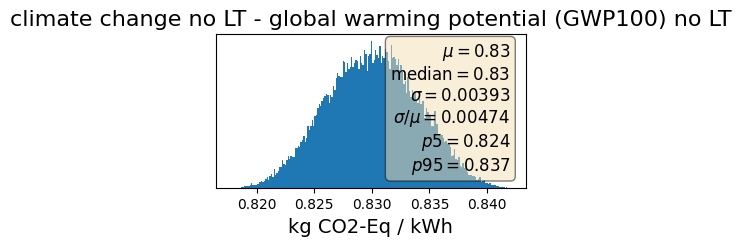

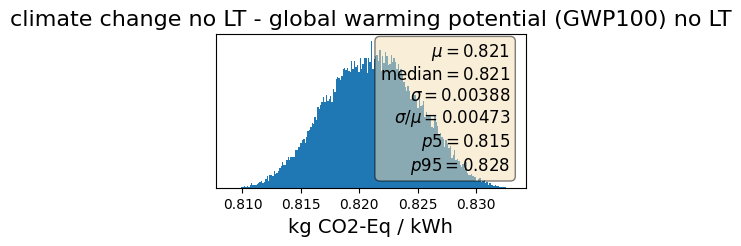

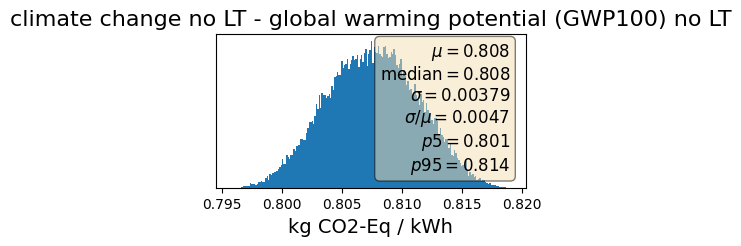

In [10]:
for diesel_final in diesel_final_allsspyear:
    agb.stats.distrib(
        diesel_final,
        [chosen_methods[0]],
        # Optional layout parameters
        percentiles=[5, 95],
        height = 2, width = 4  #height: Height of graph : 10 inches be default width : Width of graphs : 15 inches by default
    )

### if I only wanna 3 SSPs

In [12]:
new_3ssplist= []
for bev_final in diesel_final_allsspyear:
    if 'PkBudg1150' not in str(bev_final): 
        new_3ssplist.append(bev_final) 

new_3ssplist

['Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2030' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2040' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2050' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2030' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2040' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP2-Base_2050' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2030' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2040' (kilogram, GLO, None),
 'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP5-Base_2050' (kilogram, GLO, None)]

In [14]:
lcia_diesel_3ssp = lcia_diesel[lcia_diesel['SSP'] != 'ssp126'] 
lcia_diesel_3ssp

,SSP,Year,GWP100kgCO2e_perkgdiesel,prm_GWP100_perkgdiesel
0,ssp119,2030,0.765528,0.219874
1,ssp119,2040,0.637501,-1.783641
2,ssp119,2050,0.562098,-3.280184
6,ssp245,2030,0.812105,0.618935
7,ssp245,2040,0.748105,0.299477
8,ssp245,2050,0.666371,-0.200341
9,ssp585,2030,0.830704,0.707562
10,ssp585,2040,0.817571,0.682525
11,ssp585,2050,0.804194,0.595209


In [17]:
# make sure using the new result df, text lable will be correct
for i in range(9):
    print(lcia_diesel_3ssp.iloc[i,3])

0.21987383908730734
-1.7836411376801335
-3.2801842406091666
0.6189348068093848
0.29947717989301337
-0.2003405789215143
0.7075623394621484
0.6825246625154362
0.5952088663841931


In [ ]:
n = 2**13
gsa_df_list_3ssp = []
for diesel_final in diesel_final_allsspyear: 
    if 'PkBudg1150' not in str(bev_final): 
        lambdas = agb.stats._preMultiLCAAlgebric((diesel_final), chosen_methods)  #sth_adjusted
        print(diesel_final)
        #for l in lambdas: print (l) 
        var_params = stats._extract_var_params(lambdas)
        problem, _, Y = stats._stochastics(lambdas, chosen_methods, n, var_params)
        print("Processing Sobol indices ...")
        sob = stats._sobols(chosen_methods, problem, Y)
    
        sob_s1 = pd.DataFrame(sob.s1, index=[p.name for p in var_params],  columns = [x for x in chosen_methods])
        #display(sob_s1)
        gsa_df_list_3ssp.append(sob_s1)
        
    else: 
        pass

'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2030' (kilogram, GLO, None)
Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2040' (kilogram, GLO, None)
Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2050' (kilogram, GLO, None)
Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential

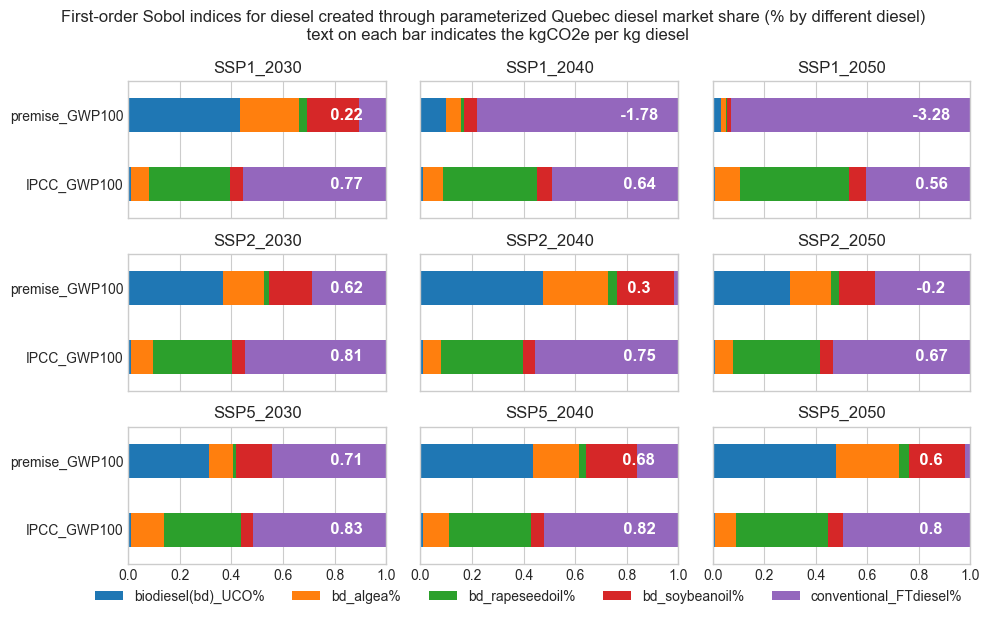

In [28]:
fig, axs = plt.subplots(3, 3, figsize=(10, 6))

# Flatten the axs array to iterate over the subplots
axs = axs.flatten()

# Plot data in each subplot
for i , diesel_final in zip(range(9), new_3ssplist):
        subtitle =  str(diesel_final.as_dict()["name"].split("remind_")[1])
        # let's only incl SSP1/2/5 + v_year for subtille
        subtitle  = subtitle.split("-")[0] + "_" + subtitle.split("_")[-1] 
        ax = axs[i]  # Select the current subplot

        df_to_p = gsa_df_list_3ssp[i] 
        # rename columns for plotting
        df_to_p = df_to_p.rename(columns={('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'): 'IPCC_GWP100' , 
                                   ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2'): 'premise_GWP100'
                                   })
    
        df_to_p.T.plot(kind='barh', stacked=True, ax=ax, legend=False)
        axs[i].set_xlim(0,1)
        axs[i].set_title(subtitle)
    
        # to get the LCIA_score from above lcia_diesel results DF, then manually add text to the subplot
        ipcc_gwp100 = round(lcia_diesel_3ssp.iloc[i,2],2)
        prem_gwp100 = round(lcia_diesel_3ssp.iloc[i,3],2)
        axs[i].text(0.83, 0, f'  {ipcc_gwp100}', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
        axs[i].text(0.83, 1, f'  {prem_gwp100}', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
        # Set y-axis to nothing if not left panels
        if i % 3 != 0:  
            axs[i].set_yticklabels([])
        if i < 6:   
            axs[i].set_xticklabels([]) 

label = ['biodiesel(bd)_UCO%', 'bd_algea%', 'bd_rapeseedoil%', 'bd_soybeanoil%', 'conventional_FTdiesel%']
fig.legend(label, loc='lower right', bbox_to_anchor=(0.98, -0.03), fancybox=False,  ncol=5)
 
fig.suptitle('First-order Sobol indices for diesel created through parameterized Quebec diesel market share (% by different diesel) \n text on each bar indicates the kgCO2e per kg diesel', fontsize=12)
plt.tight_layout()
plt.show()

### for all 4 SSPs

In [17]:
#agb.stats._preMultiLCAAlgebric?
n = 2**10
gsa_df_list = []
for diesel_final in diesel_final_allsspyear: 
    lambdas = agb.stats._preMultiLCAAlgebric((diesel_final), chosen_methods)  #sth_adjusted
    print(diesel_final)
    #for l in lambdas: print (l) 
    var_params = stats._extract_var_params(lambdas)
    problem, _, Y = stats._stochastics(lambdas, chosen_methods, n, var_params)
    print("Processing Sobol indices ...")
    sob = stats._sobols(chosen_methods, problem, Y)

    sob_s1 = pd.DataFrame(sob.s1, index=[p.name for p in var_params],  columns = [x for x in chosen_methods])
    #display(sob_s1)

    gsa_df_list.append(sob_s1)

    #sns.set(font_scale=1)
    #sns.set_style('whitegrid')
    #ax = sob_s1.T.plot(kind='barh',stacked=True,figsize=(11,6)) #, color=colors
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=False, shadow=False, ncol=3, frameon = True)
    #ax.set_xlim(0,1)
    #ax.set_title('First-order Sobol indices per impact category')
    
    #plt.tight_layout()
    #plt.show()

'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2030' (kilogram, GLO, None)
Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2040' (kilogram, GLO, None)
Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT')
Processing sobol for ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2')
'Diesel_mix_with_conv_and_biodiesel_perkg__wh__remind_SSP1-PkBudg500_2050' (kilogram, GLO, None)
Generating samples ...
Transforming samples ...
Processing Sobol indices ...
Processing sobol for ('IPCC 2021 no LT', 'climate change no LT', 'global warming potential

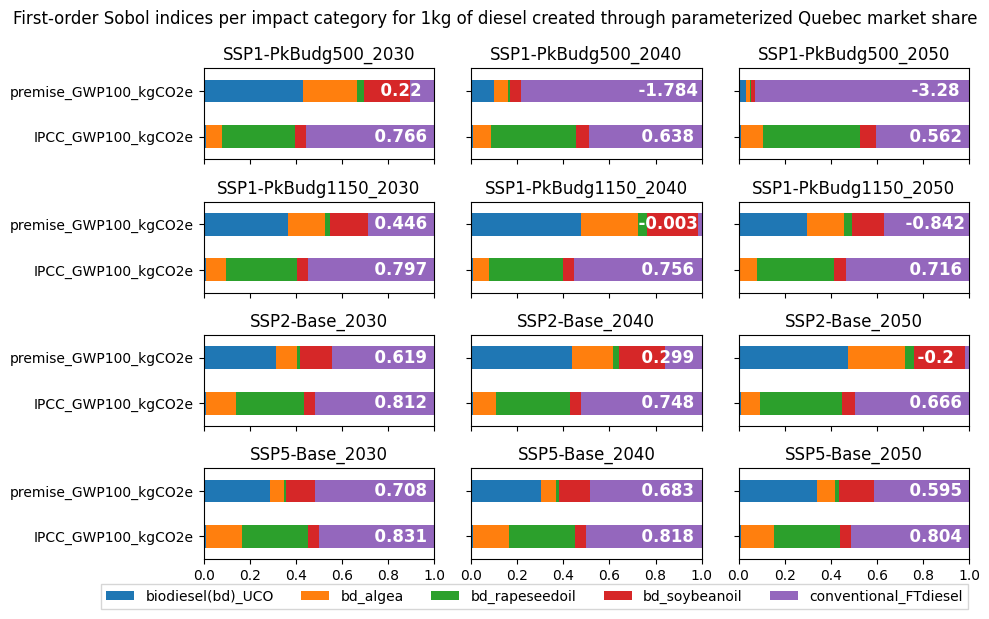

In [18]:
fig, axs = plt.subplots(4, 3, figsize=(10, 6))

# Flatten the axs array to iterate over the subplots
axs = axs.flatten()

# Plot data in each subplot
for i , diesel_final in zip(range(12), diesel_final_allsspyear):

    subtitle =  str(diesel_final.as_dict()["name"].split("remind_")[1])
    ax = axs[i]  # Select the current subplot
    
    df_to_p = gsa_df_list[i] 
    # rename columns for plotting
    df_to_p = df_to_p.rename(columns={('IPCC 2021 no LT', 'climate change no LT', 'global warming potential (GWP100) no LT'): 'IPCC_GWP100_kgCO2e' , 
                               ('IPCC 2021', 'climate change', 'GWP 100a, incl. H and bio CO2'): 'premise_GWP100_kgCO2e'
                               })

    df_to_p.T.plot(kind='barh', stacked=True, ax=ax, legend=False)
    axs[i].set_xlim(0,1)
    axs[i].set_title(subtitle)

    # to get the LCIA_score from above lcia_diesel results DF, then manually add text to the subplot
    ipcc_gwp100 = round(lcia_diesel.iloc[i,2],3)
    prem_gwp100 = round(lcia_diesel.iloc[i,3],3)
    axs[i].text(0.83, 0, f'  {ipcc_gwp100}', ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    axs[i].text(0.83, 1, f'  {prem_gwp100}', ha='center', va='center', fontsize=12, fontweight='bold', color='white')

    # Set y-axis to nothing if not left panels
    if i % 3 != 0:  
        axs[i].set_yticklabels([])
    if i < 9:  # Indices 0-8 correspond to the top 9 subplots
        axs[i].set_xticklabels([]) 
 
label = ['biodiesel(bd)_UCO', 'bd_algea', 'bd_rapeseedoil', 'bd_soybeanoil', 'conventional_FTdiesel']
fig.legend(label, loc='lower right', bbox_to_anchor=(0.98, -0.03), fancybox=False,  ncol=5)
 
fig.suptitle('First-order Sobol indices per impact category for 1kg of diesel created through parameterized Quebec market share', fontsize=12)
plt.tight_layout()
plt.show()